In [9]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahoorshams","key":"2b5ec3a9e9700362b646e3b095c12b8d"}'}

In [10]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [11]:
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [12]:
import pandas as pd

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Show top rows
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


🔍 What Are We Looking For?

 1.   What features exist?

2.  What's the shape of the data?

3. Are there missing values?

4.    What's the class distribution?



In [13]:
# Shape of dataset
print("Shape :", df.shape)

# Check for null values
print("Missing Values :\n", df.isnull().sum())

# Class balance
print("\nClass Distribution :\n", df['Class'].value_counts())

# Percentage of frauds
fraud_rate = df['Class'].value_counts(normalize=True)[1]* 100
print(f"\nFraudulent transactions: {fraud_rate:.4f}%")

Shape : (284807, 31)
Missing Values :
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Class Distribution :
 Class
0    284315
1       492
Name: count, dtype: int64

Fraudulent transactions: 0.1727%


🧠 Interpretation

*    You'll see that most features are anonymized (V1–V28)
*  Amount and Time are not scaled
* The dataset is extremely imbalanced (<<1% fraud)



In [14]:
from sklearn.preprocessing import StandardScaler

# Create a copy to keep original safe
data = df.copy()

# Drop 'Time' feature
data.drop('Time', axis = 1, inplace=True)

# Scale 'Amount' feature
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])

In [15]:
# Count of classes
data['Class'].value_counts()

,count
Class,
0,284315
1,492


You'll see a heavy imbalance (0 = non-fraud, 1 = fraud).




💡 Why It Matters

In real enterprise projects, imbalanced data leads to:

 *   High accuracy but low fraud detection

 *   Need for better metrics: Precision, Recall, F1, not just accuracy


______________________________________________________________________________

In [16]:
from sklearn.model_selection import train_test_split

X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


✅ STEP 5: Baseline Models + Cross-Validation

Let’s try a few models first:

*   Logistic Regression

*    Random Forest

*   XGBoost

And evaluate using:

*    Cross-validation

*    Precision / Recall / F1

*    ROC AUC

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

🔁 5.2 Cross-Validation

Let’s use 5-fold cross-validation on F1 Score (good for imbalanced data):

In [18]:
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score))
    print(f"{name} F1 (CV mean): {scores.mean():.4f}")

Logistic Regression F1 (CV mean): 0.1141
Random Forest F1 (CV mean): 0.8199


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:50:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:50:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:50:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:50:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:50:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost F1 (CV mean): 0.8559


💡 Why We Do This


Concept	--->   Why It Matters
         
* Cross-validationPrevents ---> overfitting to one split of the data


* Class weights / scale_pos_weight	---> Helps model learn despite class imbalance



* F1 Score         --->  Balances precision (low false positives) and recall (low false negatives)



*  Regularization  --->	Prevents overly complex models from fitting noise

In [19]:
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(
    log_reg,
    param_grid_lr,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)

print("🔹 Logistic Regression Best F1 Score:", grid_lr.best_score_)
print("🔹 Best Params:", grid_lr.best_params_)


🔹 Logistic Regression Best F1 Score: 0.1157997961949202
🔹 Best Params: {'C': 0.01}


In [20]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}

grid_rf = GridSearchCV(rf, param_grid_rf, scoring='f1', cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("🔹 Random Forest Best F1 Score:", grid_rf.best_score_)
print("🔹 Best Params:", grid_rf.best_params_)


🔹 Random Forest Best F1 Score: 0.8259962183659608
🔹 Best Params: {'max_depth': None, 'n_estimators': 50}


In [21]:
xgb = XGBClassifier(scale_pos_weight=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, scoring='f1', cv=5, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("🔹 XGBoost Best F1 Score:", grid_xgb.best_score_)
print("🔹 Best Params:", grid_xgb.best_params_)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:40:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔹 XGBoost Best F1 Score: 0.8559310586169783
🔹 Best Params: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}


In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Train final model
final_model = XGBClassifier(
    scale_pos_weight=100,
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.3,
    max_depth=6,
    n_estimators=100,
    random_state=42
)
final_model.fit(X_train, y_train)

# Predict
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:43:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [23]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56853    11]
 [   15    83]]
ROC AUC Score: 0.9743842810055929


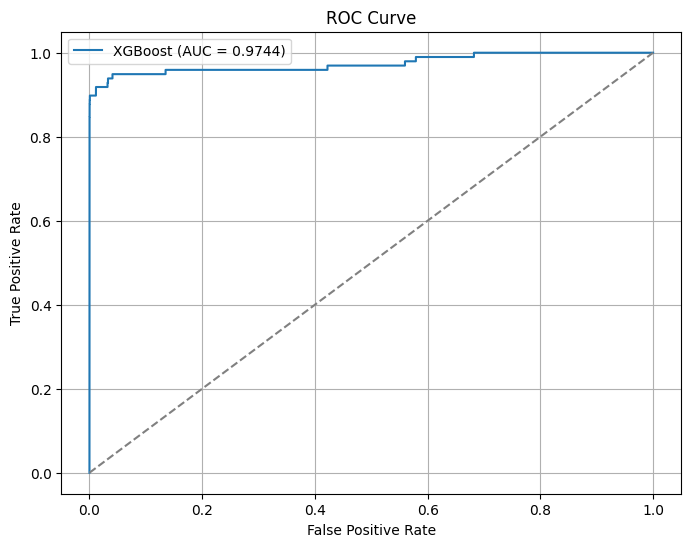

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.4f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
